<a href="https://colab.research.google.com/github/erfanbyt/pytorch/blob/main/DNN_over_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



image.shape: torch.Size([1, 28, 28])
Label: 5


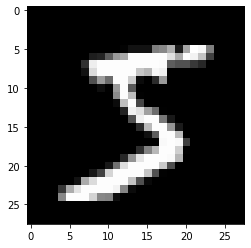

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size = 128

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


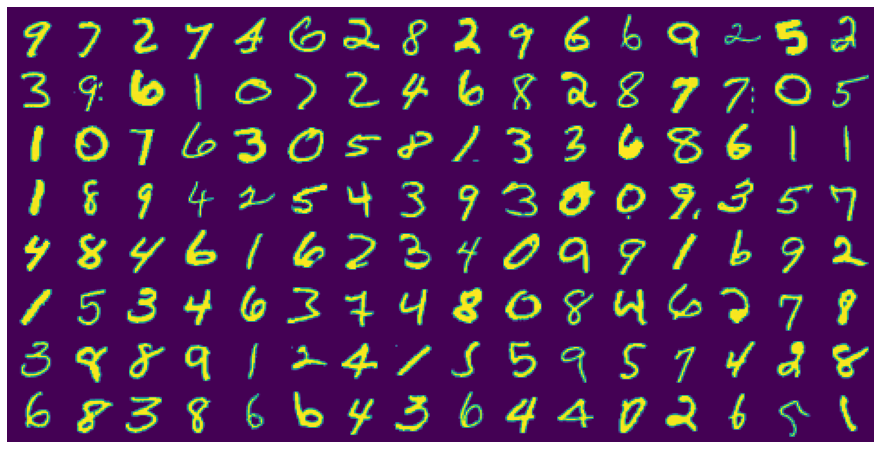

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16)[0])
    break

### model

In [8]:
class MNISTModel(nn.Module):
  def __init__(self, in_size, hidden_size, out_size) -> None:
     super().__init__()
     # hidden layer 
     self.linear1 = nn.Linear(in_size, hidden_size)
     # output layer
     self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    xb = xb.reshape(xb.shape[0], -1)
    # result first layer
    out = self.linear1(xb)
    # result second layer
    out = self.linear2(out)
    
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'acc_loss': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['acc_loss'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epochs, epoch, result):
    print("Epoch [{}/{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, epoch, result['val_loss'], result['val_acc']))


In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [11]:
model = MNISTModel(input_size, hidden_size, num_classes)

In [12]:
model

MNISTModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

### setting up GPU

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cpu')

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
# to_device(model, device)

### training the model

In [16]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):
    # training phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epochs, epoch, result)
    history.append(result)
  return history

In [17]:
# Model (on GPU)
model = MNISTModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MNISTModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [18]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.322479248046875, 'val_acc': 0.07871093600988388}]

In [19]:
hisotry = fit(10, 0.1, model, train_loader, val_loader)

Epoch [0/0], val_loss: 0.3635, val_acc: 0.8969
Epoch [1/1], val_loss: 0.3249, val_acc: 0.9059
Epoch [2/2], val_loss: 0.3107, val_acc: 0.9095
Epoch [3/3], val_loss: 0.3072, val_acc: 0.9112
Epoch [4/4], val_loss: 0.2958, val_acc: 0.9157
Epoch [5/5], val_loss: 0.2928, val_acc: 0.9177
Epoch [6/6], val_loss: 0.3084, val_acc: 0.9085
Epoch [7/7], val_loss: 0.2898, val_acc: 0.9182
Epoch [8/8], val_loss: 0.2950, val_acc: 0.9157
Epoch [9/9], val_loss: 0.2979, val_acc: 0.9146
